# Supervised Learning Energy Modeling

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import pickle

In [2]:
from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.metrics import r2_score, mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
import xgboost as xgb

#### Feature Importance:
From PyCaret Model Evaluation we find that the top 10 features are:
- Point_34: "A1SAK" - Set Point
- Point_17: "A1LPS" - Total Flow
- Point_37: "A1SAT" - Supply Air Temp
- Point_21: "A1MAT" - Mixed Air Temp
- Point_194: "MUA1SAT" - Make Up Air Unit 1 Supply Temp
- Point_26: "A1MXRT" - Max Room Temp
- Point_22: "A1MNRE" - Min Room Error
- Point_9: "A1CO2" - Return Carbon Dioxide
- Point_13: "A1DP" - Duct Pressure Point
- Point_23: "A1MNRT" - Min Room Temp

But we should also look at:
- Point_ 10: "A1DAY" - Air Handling Unit Supply Fan
    - Note: This is the only categorical feature. But it could be interesting to look at. If value is ON that means the building is occupied.

This makes 11 features that are found to be most correlated with Hourly Energy Consumption, and should be good predictors.

On second iteration in PyCaret, these features were the top 10. Two new features appeared with high importance:
- Point_37
- Point_34
- Point_17
- Point_13
- **Point_90: "AVOAT" - Average Outside Air Temp
- Point_21
- Point_194
- **Point_198: "MUA2SAT" - Make Up Air Unit 2 Supply Temp
- Point_26
- Point_22

This makes 13 features in total.

In [3]:
# load clean data
df = pd.read_csv('raw_data/model_data_v1.csv')

/Users/daylin/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (27,38,39,67,77,106,163) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
features_iter1 = ['Hourly Energy Cons (kWh)', 'Point_34', 'Point_17', 'Point_37', 'Point_21', 'Point_194',
                  'Point_26', 'Point_22', 'Point_9', 'Point_13', 'Point_23', 'Point_10']
features_iter2 = ['Hourly Energy Cons (kWh)', 'Point_34', 'Point_17', 'Point_37', 'Point_21', 'Point_194',
                  'Point_26', 'Point_22', 'Point_9', 'Point_13', 'Point_23', 'Point_90', 'Point_198', 'Point_10']

In [5]:
df_feat = df[features_iter2].copy()

In [6]:
df_feat

,Hourly Energy Cons (kWh),Point_34,Point_17,Point_37,Point_21,Point_194,Point_26,Point_22,Point_9,Point_13,Point_23,Point_90,Point_198,Point_10
0,15.0,17.8,513,18.9,15.5,17.4,21.3,1.7,413,18,18.0,14.4,17.1,OFF
1,15.0,17.8,513,16.9,15.5,16.8,20.7,0.5,413,18,18.0,13.9,17.1,OFF
2,10.0,17.8,513,16.9,13.5,16.3,20.7,0.5,413,18,17.4,13.3,16.5,OFF
3,15.0,17.8,513,16.9,13.5,16.3,20.2,0.5,413,18,17.4,12.8,16.5,OFF
4,15.0,17.8,513,16.9,13.5,16.3,20.2,0.5,413,18,16.9,12.8,16.0,ON
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8754,10.0,24.2,218,24.7,26.0,26.4,25.1,5.2,397,24,22.2,23.8,26.1,OFF
8755,15.0,24.2,218,24.7,28.0,25.9,24.6,5.2,397,24,22.2,23.2,26.1,OFF
8756,15.0,24.2,218,24.7,28.0,25.3,24.6,5.2,397,24,22.2,23.1,24.9,OFF
8757,25.0,24.2,218,24.7,26.0,24.2,24.6,5.2,397,24,22.2,21.4,24.4,OFF


In [7]:
df_feat.dtypes

Hourly Energy Cons (kWh)    float64
Point_34                    float64
Point_17                      int64
Point_37                    float64
Point_21                    float64
Point_194                   float64
Point_26                    float64
Point_22                    float64
Point_9                       int64
Point_13                      int64
Point_23                    float64
Point_90                    float64
Point_198                   float64
Point_10                     object
dtype: object

In [8]:
df_feat.isnull().sum()

Hourly Energy Cons (kWh)    0
Point_34                    0
Point_17                    0
Point_37                    0
Point_21                    0
Point_194                   0
Point_26                    0
Point_22                    0
Point_9                     0
Point_13                    0
Point_23                    0
Point_90                    0
Point_198                   0
Point_10                    0
dtype: int64

In [9]:
df_feat.describe()

,Hourly Energy Cons (kWh),Point_34,Point_17,Point_37,Point_21,Point_194,Point_26,Point_22,Point_9,Point_13,Point_23,Point_90,Point_198
count,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000,8759.000000
mean,24.682612,21.502398,1876.525973,21.093675,20.189999,19.061971,23.206325,-0.267439,446.183811,114.315447,19.323781,13.028816,18.574015
std,12.692877,5.174269,1887.459660,4.203152,4.000844,3.800795,1.905135,3.277519,45.515758,126.059888,2.385430,6.243140,3.963442
min,0.000000,10.000000,0.000000,9.900000,11.300000,13.100000,19.300000,-9.100000,396.000000,8.000000,14.900000,-1.200000,12.900000
25%,15.000000,17.100000,334.000000,17.900000,17.300000,15.400000,21.700000,-2.700000,410.000000,15.000000,17.100000,7.900000,14.900000
50%,20.000000,20.700000,651.000000,20.600000,20.100000,18.900000,23.700000,-1.500000,447.000000,22.000000,20.000000,12.300000,18.300000
75%,35.000000,26.000000,3565.000000,24.000000,22.000000,21.100000,24.400000,2.600000,477.000000,210.000000,21.300000,17.800000,20.900000
max,75.000000,32.300000,7474.000000,32.200000,39.400000,33.500000,34.200000,10.100000,729.000000,478.000000,26.200000,32.300000,32.600000


In [10]:
df_feat.Point_10.unique()

array(['OFF', 'ON'], dtype=object)

# Modeling

In [11]:
y = df_feat['Hourly Energy Cons (kWh)']
X = df_feat.drop(['Hourly Energy Cons (kWh)'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3832)

In [12]:
print(X_train.shape)
print(X_test.shape)

(6131, 13)
(2628, 13)


In [13]:
# separate categorical columns and numerical columns
categorical_cols = [cname for cname in X_train.columns if X_train[cname].dtype == "object"]

numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64']]

In [14]:
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())
                                        ])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))
                                        ])
                                        
# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_cols),
                                               ('cat', categorical_transformer, categorical_cols)
                                               ])

# Define model
rf_reg = RandomForestRegressor(random_state=3832)
gb_reg = GradientBoostingRegressor(random_state=3832)
xgboost = xgb.XGBRegressor()
lgboost = lgb.LGBMRegressor(num_leaves=31, n_estimators=100, max_depth=-1,
                            learning_rate=0.1, random_state=3832, min_child_samples=20,
                            min_child_weight=0.001, min_split_gain=0.0, reg_alpha=0, reg_lambda=0,
                            subsample=1.0, colsample_bytree=1.0)

In [15]:
# Display HTML representation in a jupyter context
from sklearn import set_config
set_config(display='diagram')

## Random Forest

In [16]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', rf_reg)])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Point_34', 'Point_17',
                                                   'Point_37', 'Point_21',
                                                   'Point_194', 'Point_26',
                                                   'Point_22', 'Point_9',
                                                   'Point_13', 'Point_23',
                                                   'Point_90', 'Point_198']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Point_10'])])),
                ('model', RandomForestRegressor(random_state=3832))])

In [17]:
base_preds = pipeline.predict(X_test)

In [18]:
print(pipeline.score(X_test,y_test))
print(r2_score(y_test, base_preds))
print(mean_absolute_error(y_test, base_preds))

0.8907245085933027
0.8907245085933027
3.0675204451074887


In [37]:
df_preds_comp = pd.DataFrame({'Actual':y_test, 'RF Predictions':base_preds})
df_preds_comp

,Actual,RF Predictions
4155,15.0,15.375
5651,45.0,46.750
8014,15.0,16.400
6940,15.0,17.170
1833,10.0,16.350
...,...,...
4280,35.0,38.800
2494,15.0,13.875
5297,40.0,44.750
6513,40.0,31.450


In [21]:
rf_importances = pipeline.steps[1][1].feature_importances_

In [22]:
rf_importances

array([0.05190957, 0.58045079, 0.01955496, 0.01644936, 0.03493333,
       0.02088217, 0.01797624, 0.02885761, 0.0865464 , 0.01488981,
       0.03048371, 0.02285741, 0.03661299, 0.03759565])

In [23]:
# most important feature
X_train.columns[1]

'Point_17'

## Gradient Boost

In [24]:
gb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', gb_reg)])

gb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Point_34', 'Point_17',
                                                   'Point_37', 'Point_21',
                                                   'Point_194', 'Point_26',
                                                   'Point_22', 'Point_9',
                                                   'Point_13', 'Point_23',
                                                   'Point_90', 'Point_198']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Point_10'])])),
                ('model', GradientBoostingRegressor(random_state=3832))])

In [25]:
gb_preds = gb_pipeline.predict(X_test)

In [26]:
print(gb_pipeline.score(X_test,y_test))
print(r2_score(y_test, gb_preds))
print(mean_absolute_error(y_test, gb_preds))

0.8683967029429782
0.8683967029429782
3.3600843679984598


In [38]:
gb_importances = gb_pipeline.steps[1][1].feature_importances_
gb_importances

array([0.02244423, 0.5786809 , 0.01270807, 0.01308699, 0.04145666,
       0.04737787, 0.01024294, 0.01860166, 0.04956945, 0.00470696,
       0.01190293, 0.01545216, 0.11407613, 0.05969306])

## XG Boost

In [39]:
xgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', xgboost)])

xgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Point_34', 'Point_17',
                                                   'Point_37', 'Point_21',
                                                   'Point_194', 'Point_26',
                                                   'Point_22', 'Point_9',
                                                   'Point_13', 'Point_23',
                                                   'Point_90', 'Point_198']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Point_10'])])),
                ('mod...
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=12, num_parallel_tree=1, random_state=0,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=None))])

In [40]:
xgb_preds = xgb_pipeline.predict(X_test)

In [41]:
print(xgb_pipeline.score(X_test,y_test))
print(r2_score(y_test, xgb_preds))
print(mean_absolute_error(y_test, xgb_preds))

0.8860204799641516
0.8860204799641516
3.1855676104307538


In [42]:
xgb_importances = xgb_pipeline.steps[1][1].feature_importances_
xgb_importances

array([0.01844553, 0.31146464, 0.0083233 , 0.00934833, 0.01610236,
       0.01457933, 0.0105266 , 0.02359586, 0.00973602, 0.00939979,
       0.01282904, 0.01076541, 0.54488385, 0.        ], dtype=float32)

## Light GBM

In [43]:
lgb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', lgboost)])

lgb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Point_34', 'Point_17',
                                                   'Point_37', 'Point_21',
                                                   'Point_194', 'Point_26',
                                                   'Point_22', 'Point_9',
                                                   'Point_13', 'Point_23',
                                                   'Point_90', 'Point_198']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Point_10'])])),
                ('model',
                 LGBMRegressor(random_state=3832, reg_alpha=0, reg_lambda=0))])

In [44]:
lgb_preds = lgb_pipeline.predict(X_test)

In [45]:
print(lgb_pipeline.score(X_test,y_test))
print(r2_score(y_test, lgb_preds))
print(mean_absolute_error(y_test, lgb_preds))

0.8898960255290922
0.8898960255290922
3.0510283400997626


In [46]:
lgb_importances = lgb_pipeline.steps[1][1].feature_importances_
lgb_importances

array([196, 251, 269, 294, 241, 263, 270, 168, 212, 199, 368, 232,  37,
         0], dtype=int32)

#### Model Persistence

In [47]:
# save model for deployment

# iteration 1 model
# filename = 'lgb_model.sav'
# pickle.dump(lgb_pipeline, open(filename, 'wb'))

In [48]:
# to load model when required
#loaded_model = pickle.load(open(filename, 'wb'))

## Feature Importance Visualization

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

In [50]:
def plot_feature_importance(importance,names,model_type):
    #Create feature importance and names arrays
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create DataFrame
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort DataFrame in order of feature importance (highest to lowest)
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    # Create bar chart
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], palette="rocket")
    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

In [51]:
print(len(rf_importances))
print(len(X_train.columns))
# add column name after Point_10 was OneHotEncoded so importances and columns are same length
postprocess_columns = list(X_train.columns.copy())
postprocess_columns.append('Point_10_OFF')

14
13


### Random Forest

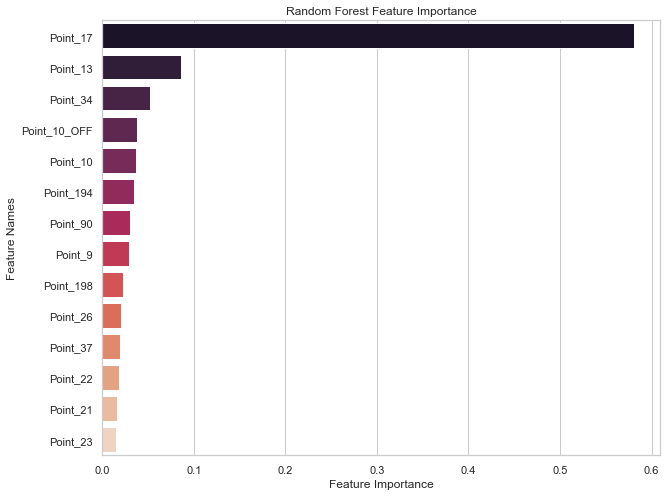

In [52]:
plot_feature_importance(rf_importances, postprocess_columns, 'Random Forest')

### Gradient Boost

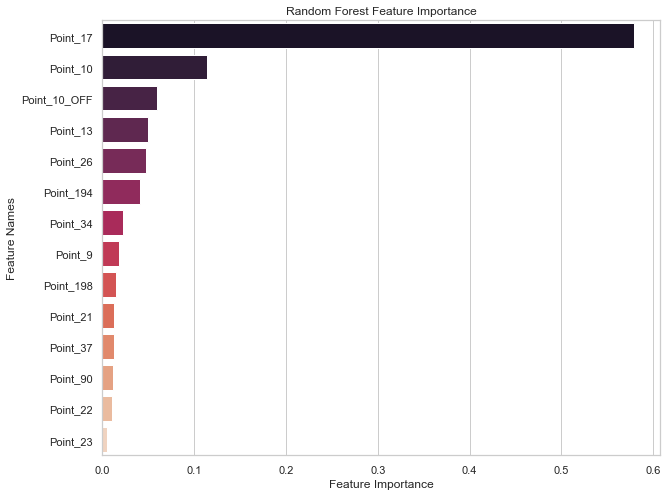

In [53]:
plot_feature_importance(gb_importances, postprocess_columns, 'Random Forest')

### XGBoost

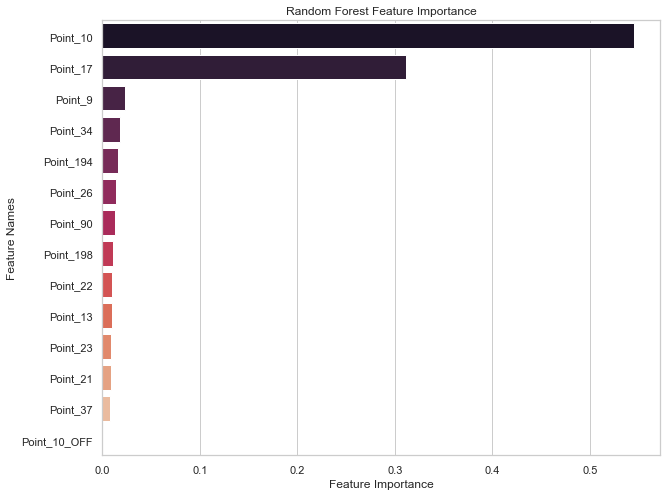

In [54]:
plot_feature_importance(xgb_importances, postprocess_columns, 'Random Forest')

### Light Gradient Boost

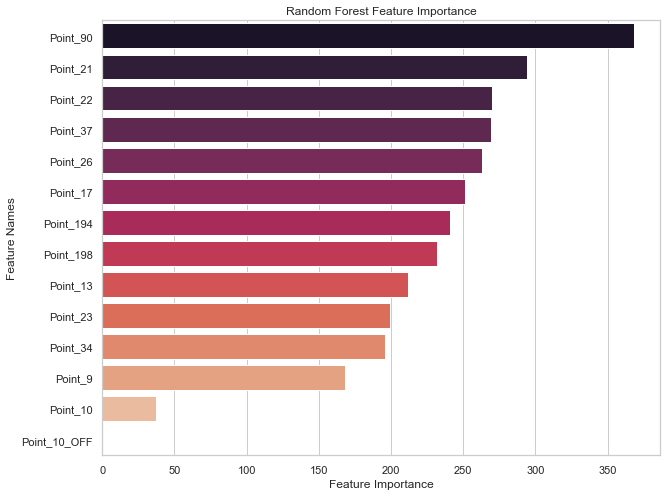

In [55]:
plot_feature_importance(lgb_importances, postprocess_columns, 'Random Forest')

**Notes:**
- Point_10 Trial: Air Handling Unit Supply Fan (Building occupied when ON)
    - All Models performed 2-3% worse when Point_10 eliminated from data set
    - Even though it is low on the importance list, it still helps model performance
    - Undoubtedly has an effect on energy consumption
- Iteration 1 models all performed well, but saw increases when features were added in iteration 2
    - Added features were the result of a second feature importance trial in PyCaret
- Models might benefit from even more features: something to test in future